In [11]:
%pip install xgboost
%pip install tabulate

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, log_loss, accuracy_score, 
    roc_curve, auc, precision_recall_curve
)
import xgboost as xgb
import json
from datetime import datetime
import matplotlib.pyplot as plt
import json 
from collections import OrderedDict

# Load data
defensive_df      = pd.read_csv(os.path.join("data/defensive_2019_2023.csv"))
receiving_df      = pd.read_csv(os.path.join("data/receiving_2019_2023.csv"))
rushing_df        = pd.read_csv(os.path.join("data/rushing_2019_2023.csv"))
passing_df        = pd.read_csv(os.path.join("data/passing_2019_2023.csv"))
fumbles_df        = pd.read_csv(os.path.join("data/fumbles_2019_2023.csv"))
interceptions_df  = pd.read_csv(os.path.join("data/interceptions_2019_2023.csv"))
kickreturns_df    = pd.read_csv(os.path.join("data/kickreturns_2019_2023.csv"))
puntreturns_df    = pd.read_csv(os.path.join("data/puntreturn_2019_2023.csv"))
kicking_df        = pd.read_csv(os.path.join("data/kicking_2019_2023.csv"))
punting_df        = pd.read_csv(os.path.join("data/punting_2019_2023.csv"))


# ============================================================================
# ECE CALCULATION (from Walsh & Joshi, 2024)
# ============================================================================

def calculate_ece(y_true, y_pred_proba, n_bins=10):
    """
    Calculate Expected Calibration Error
    
    Args:
        y_true: True binary labels (0 or 1)
        y_pred_proba: Predicted probabilities [0, 1]
        n_bins: Number of bins for calibration (default 10)
    
    Returns:
        ece: Expected Calibration Error
        bin_data: DataFrame with per-bin statistics
    """
    bins = np.linspace(0, 1, n_bins + 1)
    # np.digitize returns bin index starting from 1, so subtract 1
    bin_indices = np.digitize(y_pred_proba, bins) - 1 
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0.0
    bin_data = [] # Stores binned data for calibration plot
    
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() == 0:
            continue
        
        bin_size = bin_mask.sum()
        bin_confidence = y_pred_proba[bin_mask].mean()
        bin_accuracy = y_true[bin_mask].mean()
        
        ece += (bin_size / len(y_true)) * abs(bin_confidence - bin_accuracy)
        
        bin_data.append({
            # 'bin': i, 'bin_lower': bins[i], 'bin_upper': bins[i + 1], # COMMENTED: Original details
            'count': int(bin_size), 
            'avg_confidence': bin_confidence,
            'avg_accuracy': bin_accuracy, 
            # 'calibration_error': abs(bin_confidence - bin_accuracy) # COMMENTED: Original details
        })
    return ece, pd.DataFrame(bin_data)

def calculate_pce(y_true, y_pred_proba, n_bins=10):
    """
    Calculate Positive Calibration Error (PCE): ECE calculated on the subset 
    of predictions where confidence >= 0.5.
    """
    positive_mask = y_pred_proba >= 0.5
    
    if positive_mask.sum() == 0:
        return 0.0 
    
    y_true_pos = y_true[positive_mask]
    y_pred_proba_pos = y_pred_proba[positive_mask]
    
    # Calculate ECE on the filtered subset (PCE)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred_proba_pos, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    pce = 0.0
    total_pos_count = len(y_true_pos)

    for i in range(n_bins):
        bin_mask = bin_indices == i
        if bin_mask.sum() == 0:
            continue
        
        bin_size = bin_mask.sum()
        bin_confidence = y_pred_proba_pos[bin_mask].mean()
        bin_accuracy = y_true_pos[bin_mask].mean()
        
        # PCE calculation: weighted average of absolute difference
        pce += (bin_size / total_pos_count) * abs(bin_confidence - bin_accuracy)
        
    return pce

def plot_calibration_curve(y_true, y_pred_proba, n_bins=10, title="Calibration Curve"):
    """Plot calibration curve"""
    ece, bin_data = calculate_ece(y_true, y_pred_proba, n_bins)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot perfect calibration
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    
    # Plot actual calibration
    if not bin_data.empty:
        ax.plot(bin_data['avg_confidence'], bin_data['avg_accuracy'], 
                'o-', label=f'Model (ECE={ece:.4f})')
    
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Actual Frequency')
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)
    
    return fig, ece


# ============================================================================
# DATA PREPARATION
# ============================================================================


# --- prepare_player_prop_data ---
def prepare_player_prop_data(df, stat_col='YDS', prop_threshold=50, additional_stat_cols=None):
    """Prepare data for binary prop prediction"""
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['athlete_id', 'date']).reset_index(drop=True)
    
    # COMMENTED: simplified list of excluded columns
    # if additional_stat_cols is None:
    #     exclude_cols = ['game_id', 'date', 'season', 'team', 'home_away', 
    #                    'opposing_team', 'athlete_id', 'display_name', 'position', 'position_abbr']
    #     additional_stat_cols = [col for col in df.columns if col not in exclude_cols]
    
    if additional_stat_cols is None:
        additional_stat_cols = ['REC', 'YDS', 'TD'] # Default for receiving demo

    for col in additional_stat_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna(subset=[stat_col])
    df['prop_outcome'] = (df[stat_col] > prop_threshold).astype(int)
    
    # Encode categorical
    le_team = LabelEncoder()
    le_opp = LabelEncoder()
    le_position = LabelEncoder()
    df['team_encoded'] = le_team.fit_transform(df['team'].fillna('UNK'))
    df['opposing_team_encoded'] = le_opp.fit_transform(df['opposing_team'].fillna('UNK'))
    df['position_encoded'] = le_position.fit_transform(df['position'].fillna('UNK'))
    df['home_away_encoded'] = (df['home_away'] == 'home').astype(int)

    feature_cols = ['team_encoded', 'opposing_team_encoded', 'position_encoded', 
                    'home_away_encoded', 'season']
    
    # Rolling features
    stat_lower = stat_col.lower()
    for window in [3, 5, 8]:
        col_name = f'{stat_lower}_rolling_{window}'
        df[col_name] = df.groupby('athlete_id')[stat_col].transform(
            lambda x: x.rolling(window, min_periods=1).mean().shift(1)
        )
        feature_cols.append(col_name)
    
    # Additional Rolling features
    for add_stat in additional_stat_cols:
        if add_stat != stat_col and add_stat in df.columns:
            for window in [3, 8]:
                col_name = f'{add_stat.lower()}_rolling_{window}'
                df[col_name] = df.groupby('athlete_id')[add_stat].transform(
                    lambda x: x.rolling(window, min_periods=1).mean().shift(1)
                )
                feature_cols.append(col_name)

    # Prop rate features
    df['prop_hit_rate_8'] = df.groupby('athlete_id')['prop_outcome'].transform(
        lambda x: x.rolling(8, min_periods=1).mean().shift(1)
    )
    feature_cols.append('prop_hit_rate_8')
    
    df[f'{stat_lower}_season_avg'] = df.groupby(['athlete_id', 'season'])[stat_col].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    feature_cols.append(f'{stat_lower}_season_avg')
    
    df['prop_season_hit_rate'] = df.groupby(['athlete_id', 'season'])['prop_outcome'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    feature_cols.append('prop_season_hit_rate')
    
    df[f'{stat_lower}_std_8'] = df.groupby('athlete_id')[stat_col].transform(
        lambda x: x.rolling(8, min_periods=2).std().shift(1)
    )
    feature_cols.append(f'{stat_lower}_std_8')
    
    df['trend'] = df[f'{stat_lower}_rolling_3'] - df[f'{stat_lower}_season_avg']
    feature_cols.append('trend')
    
    df['game_num'] = df.groupby(['athlete_id', 'season']).cumcount() + 1
    feature_cols.append('game_num')
    
    df['career_games'] = df.groupby('athlete_id').cumcount()
    feature_cols.append('career_games')
    
    df = df.fillna(0)
    feature_cols = list(dict.fromkeys(feature_cols)) # Deduplicate
    
    return df, feature_cols, le_team, le_opp, le_position

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
def train_prop_model(df, stat_col, threshold, category_name, 
                     additional_stats=None, params=None):
    """Train prop model and return metrics, predictions, and the model object."""
    
    prepared_df, feature_cols, le_team, le_opp, le_position = prepare_player_prop_data(
        df, stat_col, threshold, additional_stats
    )
    
    if len(prepared_df) < 100:
        return None
    
    X = prepared_df[feature_cols].values
    y = prepared_df['prop_outcome'].values
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    if params is None:
        params = {
            'objective': 'binary:logistic', 'max_depth': 6, 'learning_rate': 0.1,
            'subsample': 0.8, 'colsample_bytree': 0.8, 'eval_metric': ['logloss', 'auc'],
            'seed': 42, 'scale_pos_weight': 1 # Keeping base parameters
        }
    
    model = xgb.train(
        params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')],
        early_stopping_rounds=50, verbose_eval=False
    )
    
    y_pred_test_proba = model.predict(dtest)
    y_pred_test = (y_pred_test_proba > 0.5).astype(int)

    # Calculate ECE and PCE
    test_ece, test_bin_data = calculate_ece(y_test, y_pred_test_proba)
    test_pce = calculate_pce(y_test, y_pred_test_proba) 
    
    test_metrics = {
        'log_loss': log_loss(y_test, y_pred_test_proba),
        'roc_auc': roc_auc_score(y_test, y_pred_test_proba),
        'accuracy': accuracy_score(y_test, y_pred_test),
        'ece': test_ece,
        'pce': test_pce 
    }
    
    return {
        'model': model, 
        'prepared_df': prepared_df, 
        'feature_cols': feature_cols,
        'y_test': y_test,
        'y_pred_proba': y_pred_test_proba,
        'test_metrics': test_metrics,
        'bin_data': test_bin_data,
        'title': f"{category_name} - {stat_col} O{threshold}"
    }


def get_single_player_prediction(model, prepared_df, player_name, feature_cols, stat_col, threshold):
    """
    Filters the prepared data for a specific player and returns the prediction 
    for their last known game (in the test set).
    """
    
    # 1. Filter the DataFrame using 'display_name'
    df_player = prepared_df[prepared_df["display_name"] == player_name]

    # 2. Ensure the player has data in the processed set
    if df_player.empty:
        return {"probability": None, "stat_val": None}
    
    # 3. Select the *last* game in the filtered dataset (the prediction target)
    player_data_point = df_player.iloc[-1]
    
    # 4. Extract features for that data point
    X_single = player_data_point[feature_cols].values.reshape(1, -1)
    
    # 5. Predict
    dmatrix_single = xgb.DMatrix(X_single)
    prob = model.predict(dmatrix_single)[0]
    
    # 6. Get the actual stat value for context
    actual_stat = player_data_point[stat_col]
    
    return {
        "probability": prob, 
        "stat_val": actual_stat,
    }

In [13]:
# ============================================================================
# 3. VISUALIZATION OF METRICS (XGBOOST PLOTTING)
# ============================================================================

def plot_xgboost_metrics_combined(y_true, y_pred_proba, bin_data, metrics, title_suffix):
    """
    Generates three plots (Calibration, ROC, Probability Distribution) 
    in the exact 1x3 layout as the TFT model's Section 14 plot.
    """
    
    # Use a clean, professional style for comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.style.use('seaborn-v0_8-whitegrid') 

    # --- Plot 1: Reliability Diagram (ECE) ---
    ece = metrics['ece']
    ax1 = axes[0]
    
    # Plot the diagonal line for perfect calibration
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Perfect Calibration')

    # Get data from the calculated bin_data
    if not bin_data.empty:
        confidences = bin_data['avg_confidence'].values
        accuracies = bin_data['avg_accuracy'].values
        
        # Calculate approximate bin width for bars
        n_bins = len(confidences)
        bin_width = 1 / n_bins 

        # Plot bars showing actual accuracy
        ax1.bar(confidences, accuracies, width=bin_width * 0.9, color='#1f77b4', alpha=0.8,
                edgecolor='black', linewidth=0.5, label='Model Accuracy')

        # Overlay confidence (center of the bin) as a line or dots to show the gap
        ax1.plot(confidences, confidences, 'o', color='red', alpha=0.7, markersize=4, label='Predicted Confidence (Center)')

        # Add lines connecting the confidence to the actual accuracy
        for c, a in zip(confidences, accuracies):
            ax1.plot([c, c], [c, a], color='orange', linestyle='-', linewidth=1.5, alpha=0.8)


    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Predicted Probability (Confidence)')
    ax1.set_ylabel('True Frequency (Accuracy)')
    ax1.set_title(f'Reliability Diagram (ECE: {ece:.4f})', fontsize=12)
    ax1.legend(loc='upper left', fontsize=8)


    # --- Plot 2: ROC Curve (AUC) ---
    ax2 = axes[1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = metrics['roc_auc']

    ax2.plot(fpr, tpr, color='C1', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate (1 - Specificity)')
    ax2.set_ylabel('True Positive Rate (Sensitivity)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
    ax2.legend(loc="lower right", fontsize=8)

    # --- Plot 3: Probability Distribution ---
    ax3 = axes[2]
    # Histogram of predicted probabilities, showing concentration
    ax3.hist(y_pred_proba, bins=20, edgecolor='black', alpha=0.7, color='#2ca02c', density=True)
    ax3.set_xlim(0, 1)
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution of Predicted Probabilities', fontsize=12)

    # Mark the 0.5 decision boundary
    ax3.axvline(0.5, color='red', linestyle=':', linewidth=1)

    plt.suptitle(f"XGBoost Model Performance Visualizations: {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()

XGBoost Training and Plotting for REC Over 5.0

Model: receiving - REC O5.0
Test Samples: 4483
Test Accuracy: 0.8860
Test ROC-AUC: 0.8242
Test ECE: 0.0177
Test PCE (NEW!): 0.0763

Single Player Prediction Demo: Travis Kelce
Prop: REC Over 5.0
Predicted Probability (Over): 0.5432
Predicted Probability (Under): 0.4568
Actual Stat Value (Last Game): 9.0
Prediction: HIT (for comparison)

XGBOOST VISUALIZATIONS (SECTION 14 LAYOUT)


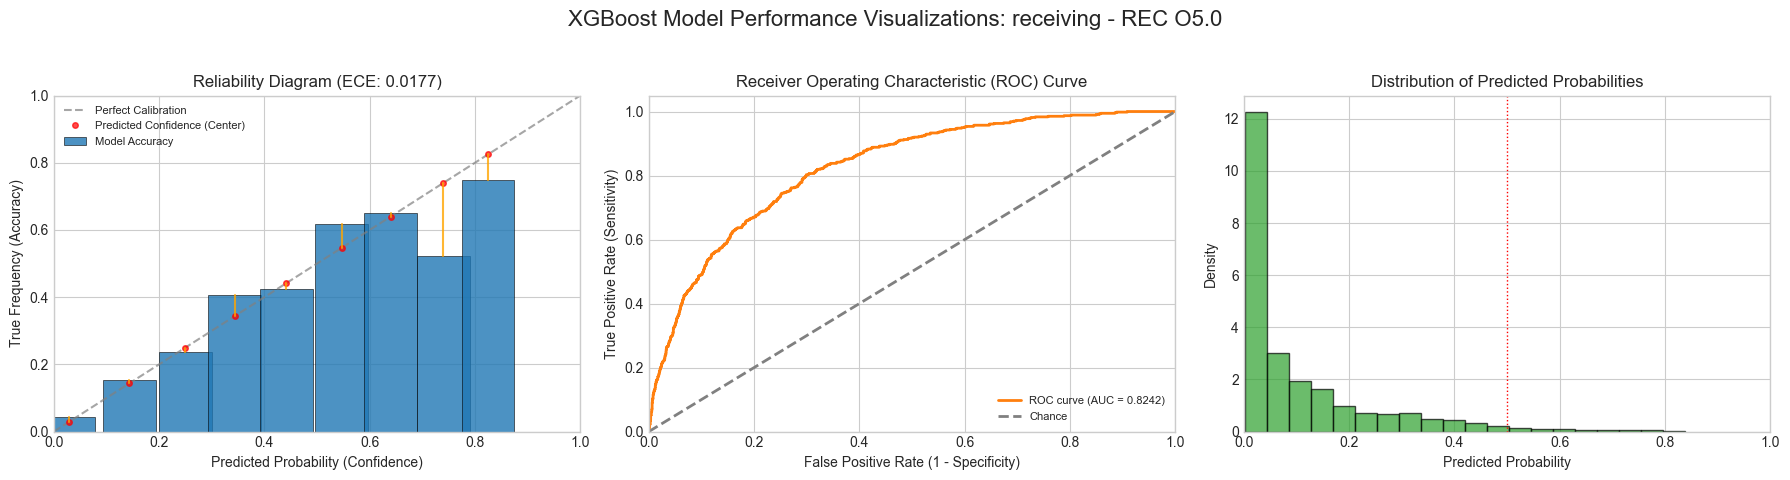

In [16]:
# ============================================================================
# 4. EXECUTION (TRAINING AND PLOTTING)
# ============================================================================

print("="*55)
print("XGBoost Training and Plotting for REC Over 5.0")
print("="*55)

# Prop configuration to match the TFT demo
CATEGORY = 'receiving'
DF = receiving_df
STAT_COL = 'REC'
THRESHOLD = 5.0 
ADDITIONAL_STATS = ['REC', 'YDS', 'TD', 'TGTS']
PLAYER_TO_PREDICT = 'Travis Kelce' 

# Train the model
training_results = train_prop_model(
    df=DF,
    stat_col=STAT_COL,
    threshold=THRESHOLD,
    category_name=CATEGORY,
    additional_stats=ADDITIONAL_STATS
)

if training_results is not None:
    # Output metrics
    test_metrics = training_results['test_metrics']
    print(f"\nModel: {training_results['title']}")
    print(f"Test Samples: {len(training_results['y_test'])}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test ROC-AUC: {test_metrics['roc_auc']:.4f}")
    print(f"Test ECE: {test_metrics['ece']:.4f}")
    print(f"Test PCE (NEW!): {test_metrics['pce']:.4f}") # Display PCE
    
    # Single Player Prediction Demo (from previous step)
    print("\n" + "="*55)
    print(f"Single Player Prediction Demo: {PLAYER_TO_PREDICT}")
    print("="*55)
    
    single_prediction = get_single_player_prediction(
        model=training_results['model'],
        prepared_df=training_results['prepared_df'],
        player_name=PLAYER_TO_PREDICT,
        feature_cols=training_results['feature_cols'],
        stat_col=STAT_COL,
        threshold=THRESHOLD
    )
    
    if single_prediction['probability'] is not None:
        prob = single_prediction['probability']
        print(f"Prop: {STAT_COL} Over {THRESHOLD}")
        print(f"Predicted Probability (Over): {prob:.4f}")
        print(f"Predicted Probability (Under): {1 - prob:.4f}")
        print(f"Actual Stat Value (Last Game): {single_prediction['stat_val']:.1f}")
        print(f"Prediction: {'HIT' if single_prediction['stat_val'] > THRESHOLD else 'MISS'} (for comparison)")
    else:
        print(f"Insufficient historical data in the test set for player: {PLAYER_TO_PREDICT}")

    # Generate Plots (New Section)
    print("\n" + "="*55)
    print("XGBOOST VISUALIZATIONS (SECTION 14 LAYOUT)")
    print("="*55)
    plot_xgboost_metrics_combined(
        y_true=training_results['y_test'],
        y_pred_proba=training_results['y_pred_proba'],
        bin_data=training_results['bin_data'],
        metrics=training_results['test_metrics'],
        title_suffix=training_results['title']
    )

In [17]:
# ============================================================================
# ADDED: STEP 5 - Save XGBoost Metrics (INCLUDING PCE) to JSON
# ============================================================================
print("\n--- Saving XGBoost Metrics for Comparison Table ---")

# Define folder path and ensure it exists
metrics_folder = 'metrics'
os.makedirs(metrics_folder, exist_ok=True) 
file_path = os.path.join(metrics_folder, 'xgboost_metrics.json') # New file path

# Set the XGBoost metrics structure, now including PCE
xgboost_metrics = {
    'ECE': test_metrics['ece'],
    'PCE': test_metrics['pce'],
    'AUC': test_metrics['roc_auc']
}

# Save to JSON file
with open(file_path, 'w') as f:
    json.dump(xgboost_metrics, f)
    
print(f"XGBoost metrics (ECE, PCE, AUC) saved to '{file_path}'.")



--- Saving XGBoost Metrics for Comparison Table ---
XGBoost metrics (ECE, PCE, AUC) saved to 'metrics/xgboost_metrics.json'.


In [18]:
# ============================================================================
# ADDED: STEP 6 - Combine and Display Comparison Table
# ============================================================================
    
# Load XGBoost metrics from the 'metrics' folder
file_path = os.path.join('metrics', 'xgboost_metrics.json')
try:
    with open(file_path, 'r') as f:
        xgb_metrics = json.load(f)
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Cannot generate comparison table.")
    xgb_metrics = {'ECE': '?', 'PCE': '?', 'AUC': '?'}

# Load tft_metrics from the 'metrics' folder
file_path = os.path.join('metrics', 'tft_metrics.json')
try:
    with open(file_path, 'r') as f:
        tft_metrics = json.load(f)
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Cannot generate comparison table.")
    tft_metrics = {'ECE': '?', 'PCE': '?', 'AUC': '?'}

# Load lstm_metrics from the 'metrics' folder
file_path = os.path.join('metrics', 'lstm_metrics.json')
try:
    with open(file_path, 'r') as f:
        lstm_metrics = json.load(f)
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Cannot generate comparison table.")
    lstm_metrics = {'ECE': '?', 'PCE': '?', 'AUC': '?'}

# Create DataFrame
data = OrderedDict({
    'Metric': ['ECE (Expected Calibration Error)', 'PCE (Positive Calibration Error)', 'AUC'],
    'TFT Model': [tft_metrics['ECE'], tft_metrics['PCE'], tft_metrics['AUC']],
    'LSTM Model': [lstm_metrics['ECE'], lstm_metrics['PCE'], lstm_metrics['AUC']],
    'XGBoost Model': [xgb_metrics['ECE'], xgb_metrics['PCE'], xgb_metrics['AUC']]
})

comparison_df = pd.DataFrame(data)

# Print Table
print("\n" + "="*70)
print("             Model Performance Comparison Table (Aggregate Metrics)             ")
print("="*70)

# Display the DataFrame as a Markdown table
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))

print("="*70)


             Model Performance Comparison Table (Aggregate Metrics)             
| Metric                           |   TFT Model |   LSTM Model |   XGBoost Model |
|:---------------------------------|------------:|-------------:|----------------:|
| ECE (Expected Calibration Error) |      0.0828 |       0.0033 |          0.0177 |
| PCE (Positive Calibration Error) |      0.5227 |       0.0830 |          0.0763 |
| AUC                              |      0.7154 |       0.5000 |          0.8242 |


## Further exploration of using transformed columns.

In [5]:

# ============================================================================
print("\n" + "="*70)
print("SECTION 3: DATA PREPARATION FUNCTIONS")
print("="*70)
# ============================================================================

def prepare_player_prop_data(df, stat_col='YDS', prop_threshold=50, additional_stat_cols=None):
    """Prepare data for binary prop prediction"""
    df = df.copy()
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['athlete_id', 'date']).reset_index(drop=True)
    
    if additional_stat_cols is None:
        exclude_cols = ['game_id', 'date', 'season', 'team', 'home_away', 
                       'opposing_team', 'athlete_id', 'display_name', 'position', 'position_abbr']
        additional_stat_cols = [col for col in df.columns if col not in exclude_cols]
    
    for col in additional_stat_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df = df.dropna(subset=[stat_col])
    df['prop_outcome'] = (df[stat_col] > prop_threshold).astype(int)
    
    le_team = LabelEncoder()
    le_opp = LabelEncoder()
    le_position = LabelEncoder()
    
    df['team_encoded'] = le_team.fit_transform(df['team'].fillna('UNK'))
    df['opposing_team_encoded'] = le_opp.fit_transform(df['opposing_team'].fillna('UNK'))
    df['position_encoded'] = le_position.fit_transform(df['position'].fillna('UNK'))
    df['home_away_encoded'] = (df['home_away'] == 'home').astype(int)
    
    feature_cols = ['team_encoded', 'opposing_team_encoded', 'position_encoded', 
                    'home_away_encoded', 'season']
    
    # Rolling features
    for window in [3, 5, 8]:
        col_name = f'{stat_col.lower()}_rolling_{window}'
        df[col_name] = df.groupby('athlete_id')[stat_col].transform(
            lambda x: x.rolling(window, min_periods=1).mean().shift(1)
        )
        feature_cols.append(col_name)
    
    for add_stat in additional_stat_cols:
        if add_stat != stat_col and add_stat in df.columns:
            for window in [3, 8]:
                col_name = f'{add_stat.lower()}_rolling_{window}'
                df[col_name] = df.groupby('athlete_id')[add_stat].transform(
                    lambda x: x.rolling(window, min_periods=1).mean().shift(1)
                )
                feature_cols.append(col_name)
    
    df['prop_hit_rate_8'] = df.groupby('athlete_id')['prop_outcome'].transform(
        lambda x: x.rolling(8, min_periods=1).mean().shift(1)
    )
    feature_cols.append('prop_hit_rate_8')
    
    df[f'{stat_col.lower()}_season_avg'] = df.groupby(['athlete_id', 'season'])[stat_col].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    feature_cols.append(f'{stat_col.lower()}_season_avg')
    
    df['prop_season_hit_rate'] = df.groupby(['athlete_id', 'season'])['prop_outcome'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    feature_cols.append('prop_season_hit_rate')
    
    df[f'{stat_col.lower()}_std_8'] = df.groupby('athlete_id')[stat_col].transform(
        lambda x: x.rolling(8, min_periods=2).std().shift(1)
    )
    feature_cols.append(f'{stat_col.lower()}_std_8')
    
    df['trend'] = df[f'{stat_col.lower()}_rolling_3'] - df[f'{stat_col.lower()}_season_avg']
    feature_cols.append('trend')
    
    df['game_num'] = df.groupby(['athlete_id', 'season']).cumcount() + 1
    feature_cols.append('game_num')
    
    df['career_games'] = df.groupby('athlete_id').cumcount()
    feature_cols.append('career_games')
    
    df = df.fillna(0)
    feature_cols = list(dict.fromkeys(feature_cols))
    
    return df, feature_cols, le_team, le_opp, le_position

# Test data preparation
print("Testing data preparation on receiving data...")
test_prepared, test_features, _, _, _ = prepare_player_prop_data(
    receiving_df.head(1000), 
    stat_col='YDS', 
    prop_threshold=50
)
print(f"Data preparation works!")
print(f"Input rows: 1000, Output rows: {len(test_prepared)}")
print(f"Number of features: {len(test_features)}")
print(f"Features: {test_features[:10]}...")
print(f"Prop outcome distribution: {test_prepared['prop_outcome'].value_counts().to_dict()}")
print(f"\nSample prepared data:")
print(test_prepared[['display_name', 'YDS', 'prop_outcome', 'yds_rolling_3', 'yds_season_avg']].head(5))


SECTION 3: DATA PREPARATION FUNCTIONS
Testing data preparation on receiving data...
Data preparation works!
Input rows: 1000, Output rows: 1000
Number of features: 25
Features: ['team_encoded', 'opposing_team_encoded', 'position_encoded', 'home_away_encoded', 'season', 'yds_rolling_3', 'yds_rolling_5', 'yds_rolling_8', 'rec_rolling_3', 'rec_rolling_8']...
Prop outcome distribution: {0: 764, 1: 236}

Sample prepared data:
       display_name  YDS  prop_outcome  yds_rolling_3  yds_season_avg
0      Jason Witten   15             0       0.000000        0.000000
1      Jason Witten   25             0      15.000000       15.000000
2      Jason Witten   54             1      20.000000       20.000000
3      Jason Witten   50             0      31.333333       31.333333
4  Larry Fitzgerald  113             1       0.000000        0.000000


In [6]:
# ============================================================================
print("\n" + "="*70)
print("SECTION 4: MODEL TRAINING FUNCTION")
print("="*70)
# ============================================================================

def train_prop_model(df, stat_col, threshold, category_name, 
                     additional_stats=None, params=None):
    """Train prop model with ECE evaluation"""
    
    print(f"\n{'='*70}")
    print(f"Training: {category_name} - {stat_col} Over {threshold}")
    print('='*70)
    
    prepared_df, feature_cols, le_team, le_opp, le_position = prepare_player_prop_data(
        df, stat_col, threshold, additional_stats
    )
    
    if len(prepared_df) < 100:
        print(f"Insufficient data: {len(prepared_df)} samples. Skipping.")
        return None
    
    X = prepared_df[feature_cols].values
    y = prepared_df['prop_outcome'].values
    
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
    print(f"Train hit rate: {y_train.mean():.2%}, Test hit rate: {y_test.mean():.2%}")
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'max_depth': 6,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': ['logloss', 'auc'],
            'seed': 42,
            'scale_pos_weight': 1
        }
    
    evals = [(dtrain, 'train'), (dtest, 'test')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    y_pred_train_proba = model.predict(dtrain)
    y_pred_test_proba = model.predict(dtest)
    y_pred_train = (y_pred_train_proba > 0.5).astype(int)
    y_pred_test = (y_pred_test_proba > 0.5).astype(int)
    
    train_ece, train_bin_data = calculate_ece(y_train, y_pred_train_proba)
    test_ece, test_bin_data = calculate_ece(y_test, y_pred_test_proba)
    
    train_metrics = {
        'log_loss': log_loss(y_train, y_pred_train_proba),
        'roc_auc': roc_auc_score(y_train, y_pred_train_proba),
        'accuracy': accuracy_score(y_train, y_pred_train),
        'ece': train_ece
    }
    
    test_metrics = {
        'log_loss': log_loss(y_test, y_pred_test_proba),
        'roc_auc': roc_auc_score(y_test, y_pred_test_proba),
        'accuracy': accuracy_score(y_test, y_pred_test),
        'ece': test_ece
    }
    
    print(f"\nTRAIN | Log Loss: {train_metrics['log_loss']:.4f} | "
          f"AUC: {train_metrics['roc_auc']:.4f} | Acc: {train_metrics['accuracy']:.4f} | "
          f"ECE: {train_metrics['ece']:.4f}")
    print(f"TEST  | Log Loss: {test_metrics['log_loss']:.4f} | "
          f"AUC: {test_metrics['roc_auc']:.4f} | Acc: {test_metrics['accuracy']:.4f} | "
          f"ECE: {test_metrics['ece']:.4f}")
    
    if test_metrics['ece'] < 0.10:
        print("Well calibrated: ECE < 0.10")
    elif test_metrics['ece'] < 0.15:
        print("Moderate calibration: 0.10 < ECE < 0.15")
    else:
        print("Poor calibration: ECE > 0.15")
    
    if test_metrics['roc_auc'] > 0.60:
        print("Task validated: AUC > 0.60")
    else:
        print("Warning: AUC < 0.60")
    
    importance = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame([
        {'feature': feature_cols[int(k[1:])], 'gain': v}
        for k, v in importance.items()
    ]).sort_values('gain', ascending=False)
    
    print(f"\n🔝 Top 5 Features:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"   {row['feature']}: {row['gain']:.2f}")
    
    fig, _ = plot_calibration_curve(
        y_test, y_pred_test_proba, 
        title=f"{category_name} {stat_col} O{threshold} - Calibration"
    )
    os.makedirs("plots", exist_ok=True)
    fig.savefig(f"plots/xgb_calibration_{category_name}_{stat_col}_{threshold}.png", dpi=150, bbox_inches='tight')
    plt.close(fig)
    
    return {
        'model': model,
        'feature_cols': feature_cols,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'importance': importance_df,
        'calibration': {
            'train_bins': train_bin_data,
            'test_bins': test_bin_data
        },
        'encoders': {
            'team': le_team,
            'opponent': le_opp,
            'position': le_position
        },
        'prepared_df': prepared_df,
        'metadata': {
            'category': category_name,
            'stat': stat_col,
            'threshold': threshold,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'train_hit_rate': float(y_train.mean()),
            'test_hit_rate': float(y_test.mean())
        }
    }

# Test single model training
print("Testing single model training on small subset...")
test_model_result = train_prop_model(
    df=receiving_df.head(2000),
    stat_col='YDS',
    threshold=50,
    category_name='receiving_test',
    additional_stats=['REC', 'YDS', 'TD', 'TGTS']
)

if test_model_result:
    print(f"\nSingle model training works!")
    print(f"   Model type: {type(test_model_result['model'])}")
    print(f"   Test AUC: {test_model_result['test_metrics']['roc_auc']:.4f}")
    print(f"   Test ECE: {test_model_result['test_metrics']['ece']:.4f}")
else:
    print("Single model training failed")


# ============================================================================
print("\n" + "="*70)
print("SECTION 5: INFERENCE FUNCTION")
print("="*70)
# ============================================================================

def predict_player_prop(player_name, stat, threshold, trained_models, 
                        receiving_df, rushing_df, passing_df):
    """
    Predict probability for a specific player prop
    
    Args:
        player_name: "Xavier Worthy"
        stat: "YDS"
        threshold: 65
        trained_models: Dictionary of trained models
        receiving_df, rushing_df, passing_df: DataFrames
    
    Returns:
        dict with probabilities and recommendation
    """
    
    # Determine category from stat
    if stat in ['REC', 'TGTS']:
        category = 'receiving'
        df = receiving_df
    elif stat == 'YDS':
        category = 'receiving'  # Default to receiving, could be improved
        df = receiving_df
    elif stat in ['CAR']:
        category = 'rushing'
        df = rushing_df
    elif stat in ['TD', 'INT']:
        category = 'passing'
        df = passing_df
    else:
        return {"error": "Cannot determine category from stat"}
    
    # Build prop name
    prop_name = f"{category}_{stat}_over_{threshold}"
    if prop_name not in trained_models:
        return {"error": f"No trained model for {prop_name}. Available models: {list(trained_models.keys())}"}
    
    model_data = trained_models[prop_name]
    model = model_data['model']
    feature_cols = model_data['feature_cols']
    prepared_df = model_data['prepared_df']
    
    # Find player in prepared data
    player_data = prepared_df[prepared_df['display_name'] == player_name].copy()
    
    if player_data.empty:
        return {"error": f"Player '{player_name}' not found in {category} data"}
    
    # Get most recent game
    latest_game = player_data.iloc[-1]
    
    # Prepare input features
    X_input = latest_game[feature_cols].values.reshape(1, -1)
    dmatrix = xgb.DMatrix(X_input, feature_names=feature_cols)
    
    # Predict
    prob_over = model.predict(dmatrix)[0]
    prob_under = 1 - prob_over
    
    return {
        'player': player_name,
        'prop': f"{stat} Over {threshold}",
        'prob_over': float(prob_over),
        'prob_under': float(prob_under),
        'recommendation': 'BET OVER' if prob_over > 0.55 else 'BET UNDER' if prob_under > 0.55 else 'NO BET',
        'confidence': float(max(prob_over, prob_under)),
        'recent_avg': float(latest_game.get(f'{stat.lower()}_rolling_3', 0)),
        'season_avg': float(latest_game.get(f'{stat.lower()}_season_avg', 0)),
        'model_ece': float(model_data['test_metrics']['ece']),
        'model_auc': float(model_data['test_metrics']['roc_auc'])
    }


# Test inference with the test model we just trained
print("Testing inference function...")
if test_model_result:
    # Get a sample player name from the prepared data (not raw receiving_df)
    prepared_df = test_model_result['prepared_df']
    
    # Find a player with multiple games
    player_counts = prepared_df['display_name'].value_counts()
    sample_player = player_counts[player_counts > 5].index[0] if len(player_counts[player_counts > 5]) > 0 else player_counts.index[0]
    
    print(f"Testing with player: {sample_player}")
    print(f"   Player has {player_counts[sample_player]} games in prepared data")
    
    # Create a minimal trained_models dict for testing
    test_trained_models = {
        'receiving_YDS_over_50': test_model_result
    }
    
    # Test the prediction
    test_prediction = predict_player_prop(
        player_name=sample_player,
        stat='YDS',
        threshold=50,
        trained_models=test_trained_models,
        receiving_df=receiving_df,
        rushing_df=rushing_df,
        passing_df=passing_df
    )
    
    if 'error' in test_prediction:
        print(f"Inference failed: {test_prediction['error']}")
    else:
        print(f"Inference function works!")
        print(f"Test player: {sample_player}")
        print(f"Prediction:")
        for key, value in test_prediction.items():
            if isinstance(value, float):
                print(f"      {key}: {value:.4f}")
            else:
                print(f"      {key}: {value}")
else:
    print("Skipping inference test (model training failed)")



SECTION 4: MODEL TRAINING FUNCTION
Testing single model training on small subset...

Training: receiving_test - YDS Over 50
Training samples: 1600, Test samples: 400
Train hit rate: 23.56%, Test hit rate: 18.00%

TRAIN | Log Loss: 0.2365 | AUC: 0.9721 | Acc: 0.9244 | ECE: 0.1001
TEST  | Log Loss: 0.4255 | AUC: 0.7328 | Acc: 0.8100 | ECE: 0.0453
Well calibrated: ECE < 0.10
Task validated: AUC > 0.60

🔝 Top 5 Features:
   yds_rolling_8: 4.74
   tgts_rolling_8: 4.50
   yds_season_avg: 4.00
   tgts_rolling_3: 3.90
   position_encoded: 3.57

Single model training works!
   Model type: <class 'xgboost.core.Booster'>
   Test AUC: 0.7328
   Test ECE: 0.0453

SECTION 5: INFERENCE FUNCTION
Testing inference function...
Testing with player: DK Metcalf
   Player has 9 games in prepared data
Inference function works!
Test player: DK Metcalf
Prediction:
      player: DK Metcalf
      prop: YDS Over 50
      prob_over: 0.5539
      prob_under: 0.4461
      recommendation: BET OVER
      confidence: 

In [19]:
# ============================================================================
print("\n" + "="*70)
print("SECTION 6: MULTI-PROP TRAINING CONFIGURATION")
print("="*70)
# ============================================================================

PROPS_CONFIG = [
    ('receiving', receiving_df, 'YDS', 50, ['REC', 'YDS', 'TD', 'TGTS']),
    ('receiving', receiving_df, 'YDS', 65, ['REC', 'YDS', 'TD', 'TGTS']),
    ('receiving', receiving_df, 'YDS', 75, ['REC', 'YDS', 'TD', 'TGTS']),
    ('receiving', receiving_df, 'REC', 5, ['REC', 'YDS', 'TD', 'TGTS']),
    ('rushing', rushing_df, 'YDS', 50, ['CAR', 'YDS', 'TD']),
    ('rushing', rushing_df, 'YDS', 75, ['CAR', 'YDS', 'TD']),
    ('passing', passing_df, 'YDS', 250, ['YDS', 'TD', 'INT']),
    ('passing', passing_df, 'TD', 1.5, ['YDS', 'TD', 'INT']),
]

print(f"Configuration loaded")
print(f"   Total props to train: {len(PROPS_CONFIG)}")
print(f"\nProps breakdown:")
for i, (cat, _, stat, thresh, _) in enumerate(PROPS_CONFIG, 1):
    print(f"   {i}. {cat} - {stat} Over {thresh}")

print("\nReady to start full training loop!")
print("   This will train all models and may take several minutes.")
print("   Proceed to Section 7 to start training.")


# ============================================================================
print("\n" + "="*70)
print("SECTION 7: FULL MULTI-PROP TRAINING LOOP")
print("="*70)
print("Uncomment the code below to run full training")
print("="*70)
# ============================================================================

# UNCOMMENT TO RUN FULL TRAINING:

trained_models = {}
results_summary = []

for category, df, stat_col, threshold, additional_stats in PROPS_CONFIG:
    prop_name = f"{category}_{stat_col}_over_{threshold}"
    
    try:
        result = train_prop_model(
            df=df,
            stat_col=stat_col,
            threshold=threshold,
            category_name=category,
            additional_stats=additional_stats
        )
        
        if result is not None:
            trained_models[prop_name] = result
            
            os.makedirs("models", exist_ok=True)
            result['model'].save_model(f"models/xgb_{prop_name}.json")
            
            results_summary.append({
                'prop': prop_name,
                'category': category,
                'stat': stat_col,
                'threshold': threshold,
                'test_auc': result['test_metrics']['roc_auc'],
                'test_accuracy': result['test_metrics']['accuracy'],
                'test_logloss': result['test_metrics']['log_loss'],
                'test_ece': result['test_metrics']['ece'],
                'train_samples': result['metadata']['train_size'],
                'test_samples': result['metadata']['test_size']
            })
    
    except Exception as e:
        print(f"Error training {prop_name}: {e}")
        continue

# ============================================================================
# SECTION 8: SUMMARY AND RESULTS
# ============================================================================

print("\n" + "="*70)
print("TRAINING COMPLETE - SUMMARY")
print("="*70)

results_df = pd.DataFrame(results_summary)

results_df_by_ece = results_df.sort_values('test_ece')
results_df_by_auc = results_df.sort_values('test_auc', ascending=False)

print(f"\nTotal models trained: {len(results_df)}")
print(f"Models with AUC > 0.60: {(results_df['test_auc'] > 0.60).sum()}")
print(f"Models with ECE < 0.10: {(results_df['test_ece'] < 0.10).sum()}")
print(f"Average Test AUC: {results_df['test_auc'].mean():.4f}")
print(f"Average Test ECE: {results_df['test_ece'].mean():.4f}")

print("\n" + "="*70)
print("BEST CALIBRATED MODELS (Lowest ECE)")
print("="*70)
print(results_df_by_ece[['prop', 'test_ece', 'test_auc', 'test_accuracy']].head(10).to_string(index=False))

print("\n" + "="*70)
print("BEST DISCRIMINATIVE MODELS (Highest AUC)")
print("="*70)
print(results_df_by_auc[['prop', 'test_auc', 'test_ece', 'test_accuracy']].head(10).to_string(index=False))

results_df.to_csv("models/training_summary_with_ece.csv", index=False)
print("\n Summary saved to models/training_summary_with_ece.csv")

# ============================================================================
# SECTION 9: EXAMPLE PREDICTIONS
# ============================================================================

print("\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)

# Find a player that exists in the data
sample_players = receiving_df['display_name'].value_counts().head(5).index.tolist()
print(f"Sample players available: {sample_players}")

for player in sample_players[:2]:
    prediction = predict_player_prop(
        player_name=player,
        stat="YDS",
        threshold=65,
        trained_models=trained_models,
        receiving_df=receiving_df,
        rushing_df=rushing_df,
        passing_df=passing_df
    )
    print(f"\n{player}:")
    print(json.dumps(prediction, indent=2))

print("\n" + "="*70)
print("ALL TESTING COMPLETE!")
print("="*70)


print("\nAll sections loaded successfully!")



SECTION 6: MULTI-PROP TRAINING CONFIGURATION
✅ Configuration loaded
   Total props to train: 8

Props breakdown:
   1. receiving - YDS Over 50
   2. receiving - YDS Over 65
   3. receiving - YDS Over 75
   4. receiving - REC Over 5
   5. rushing - YDS Over 50
   6. rushing - YDS Over 75
   7. passing - YDS Over 250
   8. passing - TD Over 1.5

⚠️  Ready to start full training loop!
   This will train all models and may take several minutes.
   Proceed to Section 7 to start training.

SECTION 7: FULL MULTI-PROP TRAINING LOOP
Uncomment the code below to run full training

Training: receiving - YDS Over 50
Training samples: 17929, Test samples: 4483
Train hit rate: 20.43%, Test hit rate: 20.72%

📊 TRAIN | Log Loss: 0.3128 | AUC: 0.9049 | Acc: 0.8692 | ECE: 0.0441
📊 TEST  | Log Loss: 0.4129 | AUC: 0.8059 | Acc: 0.8099 | ECE: 0.0373
✅ Well calibrated: ECE < 0.10
✅ Task validated: AUC > 0.60

🔝 Top 5 Features:
   yds_rolling_8: 44.41
   tgts_rolling_8: 14.41
   position_encoded: 12.38
   yd

In [ ]:
def plot_xgboost_metrics_combined(y_true, y_pred_proba, bin_data, metrics, title_suffix, n_bins=10):
    """Generates the 3-panel plot in the requested layout."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"XGBoost Model Performance: {title_suffix} (Evaluation on Test Set)", fontsize=16)

    # --- Plot 1: Calibration Curve (Reliability Diagram) ---
    ece = metrics['ece']
    ax = axes[0]
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    if not bin_data.empty:
        # Re-using the bin_data calculated during training
        ax.plot(bin_data['avg_confidence'], bin_data['avg_accuracy'], 
                'o-', label=f'Model (ECE={ece:.4f})')
        
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Actual Frequency')
    ax.set_title('Calibration Curve (Reliability Plot)')
    ax.legend()
    ax.grid(alpha=0.3)

    # --- Plot 2: ROC Curve ---
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = metrics['roc_auc']
    
    ax = axes[1]
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)

    # --- Plot 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    
    ax = axes[2]
    ax.plot(recall, precision, color='darkgreen', lw=2, label='Precision-Recall curve')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc="lower left")
    ax.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
print("="*55)
print("XGBoost Training and Plotting for REC Over 5")
print("="*55)

# Prop configuration to match Section 13 (Travis Kelce/Rashee Rice REC Over 5.0)
CATEGORY = 'receiving'
DF = receiving_df
STAT_COL = 'REC'
THRESHOLD = 5
ADDITIONAL_STATS = ['REC', 'YDS', 'TD', 'TGTS']

# Train the model
training_results = train_prop_model(
    df=DF,
    stat_col=STAT_COL,
    threshold=THRESHOLD,
    category_name=CATEGORY,
    additional_stats=ADDITIONAL_STATS
)

if training_results is not None:
    # Output metrics
    test_metrics = training_results['test_metrics']
    print(f"\nModel: {training_results['title']}")
    print(f"Test Samples: {len(training_results['y_test'])}")
    print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Test ROC-AUC: {test_metrics['roc_auc']:.4f}")
    print(f"Test ECE: {test_metrics['ece']:.4f}")
    
    # Generate Plots
    print("\n" + "="*55)
    print("XGBOOST VISUALIZATIONS (SECTION 13 LAYOUT)")
    print("="*55)
    plot_xgboost_metrics_combined(
        y_true=training_results['y_test'],
        y_pred_proba=training_results['y_pred_proba'],
        bin_data=training_results['bin_data'],
        metrics=training_results['test_metrics'],
        title_suffix=training_results['title']
    )
else:
    print("Training failed: Insufficient data for the specified prop.")